In [2]:
import pandas as pd
import numpy as np

# Get params from csv
paramDF = pd.read_csv('DICE2016R3Parameters.csv')
params = dict(zip(paramDF.key,paramDF.value))
params["numPeriods"] = int(params["numPeriods"])
params['capital_share'] = 0.3
params['initial_green_share'] = 0.05

paramDF.head()

,key,value,description
0,numPeriods,100.0,The number of periods
1,fosslim,6000.0,Maximum cumulative extraction fossil fuels (GtC)
2,tstep,5.0,Years per period
3,ifopt,1.0,Indicator where optimized is 1 and base is 0
4,p2018,1.2,Price level 2018 relative to 2010


In [3]:
# Reflation
params["q0"] = params["q0"]*params["p2018"]
params["k0"] = params["k0"]*params["p2018"]
params["cprice0"] = params["cprice0"]*params["p2018"]
params["pback"] = params["pback"]*params["p2018"]
params["a0"] = params["a0"]*params["p2018"]**(1-params["gama"])

In [4]:
# Carbon cycle matrix
params["b11"] = 1 - params["b12"]
params["b21"] = params["b12"] * params["mateq"] / params["mueq"]
params["b22"] = 1 - params["b21"] - params["b23"]
params["b32"] = params["b23"] * params["mueq"] / params["mleq"]
params["b33"] = 1 - params["b32"]
params["a20"] = params["a2"] # to store the damage parameter for different scenarios

# Preliminary calculations
params["sig0"] = params["e0"] /  (params["q0"] * (1 - params["miu0"])) # Carbon intensity in 2010
params["lam"] = params["fco22x"] / params["t2xco2"] # Climate model parameter
params["optlrsav"] = (params["dk"] + 0.004) / (params["dk"] + 0.004 * params["elasmu"] + params["prstp"]) * params["gama"]   # Optimal long-run savings rate used for transversality

In [5]:
def getPopulation(maxPeriods,pop0,popasym,popadj):
    """
    Projected population (l)
    
    pop0 : initial population (in millions)
    popasym : asymptotic population (in millions)
    popadj : growth rate to calibrate to 2050 pop projection
    
    Gams code : loop(t, l(t+1)=l(t)*(popasym/L(t))**popadj ;);
    """
    population = {}
    population[1] = pop0

    for t in range(2,maxPeriods +1):
        population[t] = population[t-1]*(popasym/population[t-1])**popadj

    return population

In [6]:
def getGrowthRateOfProductivity(ga0,dela,numPeriods,tstep):
    """
    Growth rate of productivity (ga)
    
    ga0 : initial growth rate for TFP per period
    dela : decline rate of TFP per period
    tstep : duration of a period ( = 5 years)
    
    Gams code : ga(t)=ga0*exp(-dela*5*((t.val-1)));
    """
    productivityGR = {} 

    for t in range(numPeriods):
        productivityGR[t+1] = ga0 * np.exp(-dela*tstep*t)

    return productivityGR

In [7]:
def getLevelOfProductivity(a0,ga,numPeriods):
    """
    Level of total factor productivity (al)

    a0 : initial level of TFP
    ga : growth rate of productivity

    Gams code : loop(t, al(t+1)=al(t)/((1-ga(t))););
    """
    productivity = {}
    productivity[1] = a0
    
    for t in range(2,numPeriods +1):
        productivity[t] = productivity[t-1]/(1-ga[t-1])
    
    return productivity

In [8]:
def getCumulativeEfficiencyImprovement(gsigma1,dsig,tstep,numPeriods):
    """
    Change in sigma (cumulative improvement of energy efficiency)
    gsigma1 : initial growth of sigma (per year)
    dsig : decline rate of decarbonization (per period)
    tstep : duration of a period (= 5 years)
    
    Gams code : loop(t,gsig(t+1)=gsig(t)*((1+dsig)**tstep) ;);
    """
    efficiency = {}
    efficiency[1] = gsigma1
    for t in range(2,numPeriods +1):
        efficiency[t] = efficiency[t-1]*((1+dsig)**tstep)
    
    return efficiency

In [9]:
def getGrowthRate(sig0,gsig,tstep,numPeriods):
    """
    CO2-equivalent-emissions output ratio (sigma)
    
    sig0 : Carbon intensity 2010
    gsig : cumulative improvement of energy efficiency (change in sigma)
    tstep : duration of a period (= 5 years)
    
    Gams code :  loop(t,sigma(t+1)=(sigma(t)*exp(gsig(t)*tstep)););
    """
    growthRate = {}
    growthRate[1] = sig0
    
    for t in range(2,numPeriods +1):
        growthRate[t] = growthRate[t-1]*np.exp(gsig[t-1]*tstep)
        
    return growthRate

In [10]:
def getBackstopPrice(pback,gback,numPeriods):
    """
    Backstop price (pbacktime)
    
    pback : cost of backstop 2010$ per tC02
    gback : initial cost decline backstop cost per period
    
    Gams code : pbacktime(t)=pback*(1-gback)**(t.val-1);
    """
    backstopPrice = {}

    for t in range(numPeriods):
        backstopPrice[t+1] = pback*(1-gback)**t

    return backstopPrice

In [11]:
def getAdjustedCostForBackstop(pbacktime,sigma,expcost2,numPeriods):
    """
    Adjusted cost for backstop (cost1)
    
    pbacktime : backstop price
    sigma : GHG output ratio
    expcost2 : exponent of control cost function
    
    Gams code : cost1(t) = pbacktime(t)*sigma(t)/expcost2/1000;
    """
    adjCost = {}
    
    for t in range(1,numPeriods +1):
        adjCost[t] = pbacktime[t] * sigma[t] / expcost2 / 1000
    
    return adjCost

In [12]:
def getEmissionsFromDeforestation(eland0,deland,numPeriods):
    """
    Emissions from deforestation (etree)
    
    eland0 : Carbon emissions from land 2015
    deland : decline rate of land emissions per period
    
    Gams code : etree(t) = eland0*(1-deland)**(t.val-1);
    """
    emissions = {}
    
    for t in range(1,numPeriods +1):
        emissions[t] = eland0 * (1 - deland)**(t-1)
    
    return emissions

In [13]:
def getCumulativeEmissionsFromLand(etree,numPeriods):
    """
    Cumulative from land (cumetree)
    
    etree : emissions from deforestation
    
    Gams code : loop(t,cumetree(t+1)=cumetree(t)+etree(t)*(5/3.666);)
    """
    cumulatem = {}
    cumulatem[1] = 100.0 
    
    for t in range(2,numPeriods +1) :
        cumulatem[t] = cumulatem[t-1] + etree[t-1]*(5/3.666)
    
    return cumulatem

In [14]:
def getAverageUtilitySocialDiscountRate(prstp,tstep,numPeriods):
    """
    Average utility social discount rate (rr)
    
    prstp : Initial rate of social time preference per year
    tstep : duration of a period
    
    Gams code : rr(t) = 1/((1+prstp)**(tstep*(t.val-1)));
    """
    utilDisc = {}
    
    for t in range(1,numPeriods +1):
        utilDisc[t] = 1./((1+prstp)**(tstep*(t-1)))
    
    return utilDisc

In [15]:
def getExogenousForcingOfOtherGreenhouseGases(fex0,fex1,numPeriods):
    """
    Exogenous forcing for other greenhouse gases (forcoth)
    
    fex0 : 2015 forcings of non CO2 GHG
    fex1 : 2100 forcings of non CO2 GHG
    
    Gams code : forcoth(t) = fex0+ (1/17)*(fex1-fex0)*(t.val-1)$(t.val lt 18)+ (fex1-fex0)$(t.val ge 18);
    """
    exogForcing = {}
    
    for t in range(1,numPeriods +1):
        if t < 18:
            exogForcing[t] = fex0 + (1./17.)*(fex1-fex0)*(t-1)
        else:
            exogForcing[t] = fex1
            
    return exogForcing

In [16]:
def getCarbonPrice(cprice0,gcprice,tstep,numPeriods):
    """
    Base Case Carbon Price (cpricebase)
    
    cprice0 : initial base carbon price
    gcprice : growth rate of base carbon price per year
    tstep : duration of a period
    
    Gams code : cpricebase(t)= cprice0*(1+gcprice)**(5*(t.val-1));
    """
    carbonPrice = {}
    
    for t in range(1,numPeriods+1):
        carbonPrice[t] = cprice0*(1+gcprice)**(tstep*(t-1))

    return carbonPrice

In [17]:
# Function to get share of green investment as a function of difference in cost of capital (e.g., lower cost of capital for green firms) and time
def getGreenShare(initial_green_share, share_green_investment_polluting, percent_green_invest_increase_among_polluting, diff_in_cost_of_capital, tstep, numPeriods):
    greenShare = {}

    initial_green_share = (1 + percent_green_invest_increase_among_polluting) * initial_green_share * share_green_investment_polluting + (1 - share_green_investment_polluting) * initial_green_share
    greenShare[1] = initial_green_share

    init_green_val = -np.log(1/initial_green_share - 1)
    
    for t in range(2,numPeriods+1):
        greenVal = init_green_val + diff_in_cost_of_capital*4 * (t-1) * tstep
        greenShare[t] = 1/(1+np.exp(-greenVal))

    return greenShare


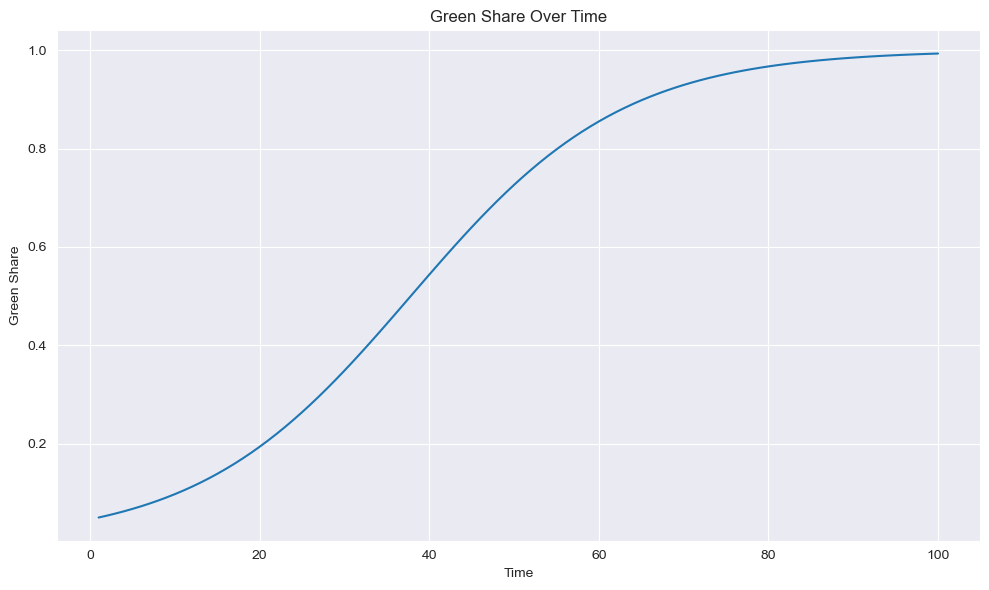

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")

# Graph green share over time
gs = getGreenShare(0.05, 0, 0, 0.02, 1, 100)
plt.figure(figsize=(10,6))
plt.plot(gs.keys(), gs.values())
plt.xlabel("Time")
plt.ylabel("Green Share")
plt.title("Green Share Over Time")
plt.tight_layout()
plt.show()

In [18]:
# Computation of the exogenous variables
params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 
params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])
params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])
params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])
params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])
params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])
params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])
params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])
params['ga'] = getGrowthRateOfProductivity(params['ga0'], params['dela'], params['numPeriods'],params['tstep'])
params['al'] = getLevelOfProductivity(params['a0'], params['ga'], params['numPeriods'])
params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])
params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])

In [19]:
import pyomo.environ as pe
import pyomo.opt as po

def diceModel2016_with_uncertainty(**kwargs):
    
    model = pe.ConcreteModel("Dice2016R3")
    
    ###SETS AND INDICES###
    model.time_periods = pe.Set(initialize=kwargs['rr'].keys()) # t = 1 .. numPeriods
    
    # Control rate limit
    def miuBounds(model,t):
        if (t == 1) and (kwargs['ifopt'] == 1):    # if optimal control on emissions
            return (kwargs['miu0'],kwargs['miu0']) # initial value
        elif t < 30:
            return (0.,1.)
        else:
            return (0.,kwargs['limmiu']) # upper limit on control rate after 2150

        
    # upper and lower bounds for stability    
    def tatmBounds(model,t):
        if t == 1: 
            return (kwargs['tatm0'],kwargs['tatm0'])  # initial value
        else:
            return (0.,20.)  # range for increase temperature in atmosphere

    def toceanBounds(model,t):
        if t == 1: 
            return (kwargs['tocean0'],kwargs['tocean0']) # initial value
        else:
            return (-1.,20.) # range for increase temperature in oceans

    def matBounds(model,t):
        if t == 1: 
            return (kwargs['mat0'],kwargs['mat0']) # initial value
        else:
            return (10.,np.inf) # range for carbon concentration increase in atmosphere

    def muBounds(model,t):
        if t == 1: 
            return (kwargs['mu0'],kwargs['mu0']) # initial value
        else:
            return (100.,np.inf) # range for carbon concentration increase in shallow oceans

    def mlBounds(model,t):
        if t == 1: 
            return (kwargs['ml0'],kwargs['ml0'])  # initial value
        else:
            return (1000.,np.inf) # range for carbon concentration in lower oceans

    def cBounds(model,t):
        return (2.,np.inf) # lower bound for consumption

    def kBounds(model,t):
        if t == 1: 
            return (kwargs['k0'],kwargs['k0']) # initial value
        else:
            return (1.,np.inf) # lower bound for capital stock

    def kGreenBounds(model,t):
        if t == 1: 
            return (kwargs['k0'] * kwargs['initial_green_share'], kwargs['k0'] * kwargs['initial_green_share']) # initial value
        else:
            return (0, np.inf) # lower bound for capital stock

    def kBrownBounds(model,t):
        if t == 1: 
            return (kwargs['k0'] * (1-kwargs['initial_green_share']), kwargs['k0'] * (1-kwargs['initial_green_share'])) # initial value
        else:
            return (0, np.inf) # lower bound for capital stock

    def cpcBounds(model,t):
        return (.01,np.inf) # lower bound for per capita consumption

    # control variable
    def sBounds(model,t):
        if t <= kwargs['numPeriods'] - 10:
            return (-np.inf,np.inf)
        else:
            return (kwargs['optlrsav'],kwargs['optlrsav']) # constraint saving rate at the end 

    # Ressource limit
    def ccaBounds(model,t):
        if t == 1:
            return (kwargs['cca0'],kwargs['cca0']) # initial value
        else:
            return (-np.inf,kwargs['fosslim']) # maximum cumulative extraction fossil fuels
        
    #Emission control rate GHGs    
    model.MIU = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=miuBounds) 
    
    # Increase in radiative forcing (watts per m2 from 1900)
    model.FORC = pe.Var(model.time_periods,domain=pe.Reals) 
    
    # Increase temperature of atmosphere (degrees C from 1900)
    model.TATM = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=tatmBounds) 
    
    # Increase temperatureof lower oceans (degrees C from 1900)
    model.TOCEAN = pe.Var(model.time_periods,domain=pe.Reals,bounds=toceanBounds) 

    # Carbon concentration increase in atmosphere (GtC from 1750)
    model.MAT = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=matBounds) 

    # Carbon concentration increase in shallow oceans (GtC from 1750)
    model.MU = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=muBounds) 

    # Carbon concentration increase in lower oceans (GtC from 1750)
    model.ML = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=mlBounds) 

    # Total CO2 emissions (GtCO2 per year)
    model.E = pe.Var(model.time_periods,domain=pe.Reals) 
    
    #Industrial emissions (GtCO2 per year)
    model.EIND = pe.Var(model.time_periods,domain=pe.Reals) 

    # Consumption (trillions 2005 US dollars per year)
    model.C = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=cBounds) 

    # Capital stock (trillions 2005 US dollars)
    model.K = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=kBounds) 

    # Per capita consumption (thousands 2005 USD per year)
    model.CPC = pe.Var(model.time_periods,domain=pe.NonNegativeReals,bounds=cpcBounds) 

    # Investment (trillions 2005 USD per year)
    model.I = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Gross savings rate as fraction of gross world product
    model.S = pe.Var(model.time_periods,domain=pe.Reals,bounds=sBounds) 

    # Real interest rate (per annum)
    model.RI = pe.Var(model.time_periods,domain=pe.Reals) 

    # Gross world product net of abatement and damages (trillions 2005 USD per year)
    model.Y = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Gross world product GROSS of abatement and damages (trillions 2005 USD per year)
    model.YGROSS = pe.Var(model.time_periods,domain=pe.NonNegativeReals) 

    # Output net of damages equation (trillions 2005 USD per year)
    model.YNET = pe.Var(model.time_periods,domain=pe.Reals) 

    # Damages (trillions 2005 USD per year)
    model.DAMAGES = pe.Var(model.time_periods,domain=pe.Reals) 

    # Damages as fraction of gross output
    model.DAMFRAC = pe.Var(model.time_periods,domain=pe.Reals) 

    # Cost of emissions reductions  (trillions 2005 USD per year)
    model.ABATECOST = pe.Var(model.time_periods,domain=pe.Reals) 

    # Marginal cost of abatement (2005$ per ton CO2)
    model.MCABATE = pe.Var(model.time_periods,domain=pe.Reals) 

    # Cumulative industrial carbon emissions (GTC)
    model.CCA = pe.Var(model.time_periods,domain=pe.Reals,bounds=ccaBounds) 
    
    # Total carbon emissions (GtC)
    model.CCATOT = pe.Var(model.time_periods,domain=pe.Reals)

    # One period utility function
    model.PERIODU = pe.Var(model.time_periods,domain=pe.Reals) 

    # Carbon price (2005$ per ton of CO2) !!! No initial upper bound in version 2016R
    model.CPRICE = pe.Var(model.time_periods,domain=pe.Reals) 

    # Period utility
    model.CEMUTOTPER = pe.Var(model.time_periods,domain=pe.Reals) 

    # Welfare function
    model.UTILITY = pe.Var(domain=pe.Reals) 

    # Green and Brown Investment Variables
    model.I_G = pe.Var(model.time_periods, domain=pe.NonNegativeReals)
    model.I_B = pe.Var(model.time_periods, domain=pe.NonNegativeReals)
    
    # Green and Brown Capital Stock
    model.K_G = pe.Var(model.time_periods, domain=pe.NonNegativeReals, bounds=kGreenBounds)
    model.K_B = pe.Var(model.time_periods, domain=pe.NonNegativeReals, bounds=kBrownBounds)

    # eeq(t)
    def emissionsEquation(model,t):
        return (model.E[t] == model.EIND[t] + kwargs['etree'][t])
    
    model.emissionsEquation = pe.Constraint(model.time_periods,rule=emissionsEquation)

    # eindeq(t)
    def industrialEmissions(model,t): 
        # EIND(t) =E= sigma(t) * YGROSS(t) * (1-(MIU(t)));
        return (model.EIND[t] == kwargs['sigma'][t] * model.YGROSS[t] * (1 - model.MIU[t]) * (model.K_B[t]/model.K[t]) * (model.K[1]/model.K_B[1]))

    model.industrialEmissions = pe.Constraint(model.time_periods,rule=industrialEmissions)

    # ccacca(t+1)
    def cumCarbonEmissions(model,t):
        if t == 1:
            return pe.Constraint.Skip # to use boundary value instead of  constraint
        else:
            return (model.CCA[t] == model.CCA[t-1] + model.EIND[t-1] * kwargs['tstep'] / 3.666)

    model.cumCarbonEmissions = pe.Constraint(model.time_periods,rule=cumCarbonEmissions)

    # ccatoteq(t)
    def totCarbonEmissions(model,t):
        return (model.CCATOT[t] == model.CCA[t] + kwargs['cumetree'][t])
    
    model.totCarbonEmissions = pe.Constraint(model.time_periods,rule=totCarbonEmissions)
    
    # force(t)
    def radiativeForcing(model,t): 
        return (model.FORC[t] == kwargs['fco22x'] * (pe.log10(model.MAT[t]/588.0)/pe.log10(2)) + kwargs['forcoth'][t])

    model.radiativeForcing = pe.Constraint(model.time_periods,rule=radiativeForcing)

    # damfraceq(t)
    def damageFraction(model,t):
        g_t = (kwargs['a1'] * model.TATM[t]) + (kwargs['a2'] * model.TATM[t]**2) + ((kwargs['catastrophic_climate'] * model.TATM[t])**7)
        return (model.DAMFRAC[t] == 1 - (1/(1 + g_t)))
                
    model.damageFraction = pe.Constraint(model.time_periods,rule=damageFraction)

    # dameq(t)
    def damagesConst(model,t):
        return (model.DAMAGES[t] == (model.YGROSS[t] * model.DAMFRAC[t]))

    model.damagesConst = pe.Constraint(model.time_periods,rule=damagesConst)

    # abateeq(t)
    def abatementCost(model,t):
        return (model.ABATECOST[t] == model.YGROSS[t] * kwargs['cost1'][t] * (model.MIU[t]**kwargs['expcost2']))

    model.abatementCost = pe.Constraint(model.time_periods,rule=abatementCost)

    # mcabateeq(t)
    def mcAbatement(model,t): 
  
        myExp = kwargs['expcost2'] - 1
        return (model.MCABATE[t] == kwargs['pbacktime'][t] * (model.MIU[t])**myExp)
          
    model.mcAbatement = pe.Constraint(model.time_periods,rule=mcAbatement)

    # carbpriceeq(t)            
    def carbonPriceEq(model,t): 
        myExp = kwargs['expcost2'] - 1
        return (model.CPRICE[t] == kwargs['pbacktime'][t] * (model.MIU[t])**myExp)

    model.carbonPriceEq = pe.Constraint(model.time_periods,rule=carbonPriceEq)

    #  dmiueq(t+1)
    def controlRateLimit(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.MIU[t] <= model.MIU[t-1] + kwargs['dmiulim'])
    
    model.controlRateLimit = pe.Constraint(model.time_periods,rule=controlRateLimit)

    ## Climate and carbon cycle
                
    # mmat(t+1)
    def atmosphericConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else: 
            #MAT(t+1) =E= MAT(t)*b11 + MU(t)*b21 + (E(t)*(tstep/3.666));
            return (model.MAT[t] == model.MAT[t-1]*kwargs['b11'] + model.MU[t-1] * kwargs['b21'] + model.E[t-1] * kwargs['tstep'] / 3.666)

    model.atmosphericConcentration = pe.Constraint(model.time_periods,rule=atmosphericConcentration)

    # mml(t+1)            
    def lowerOceanConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.ML[t] == model.ML[t-1]*kwargs['b33'] + model.MU[t-1] * kwargs['b23'] )

    model.lowerOceanConcentration = pe.Constraint(model.time_periods,rule=lowerOceanConcentration)

    # mmu(t+1)
    def upperOceanConcentration(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.MU[t] == model.ML[t-1]*kwargs['b32'] + model.MU[t-1] * kwargs['b22'] + model.MAT[t-1] * kwargs['b12'])

    model.upperOceanConcentration = pe.Constraint(model.time_periods,rule=upperOceanConcentration)

    # tatmeq(t+1)
    def atmosphericTemperature(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else: 
            return (model.TATM[t] == model.TATM[t-1] + kwargs['c1'] * ((model.FORC[t] - (kwargs['fco22x']/kwargs['t2xco2'])*model.TATM[t-1]) \
                                                                       - (kwargs['c3'] * (model.TATM[t-1] - model.TOCEAN[t-1]))))

    model.atmosphericTemperature = pe.Constraint(model.time_periods,rule=atmosphericTemperature)

    # toceaneq(t+1)            
    def oceanTemperature(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.TOCEAN[t] == model.TOCEAN[t-1] + kwargs['c4'] * (model.TATM[t-1] - model.TOCEAN[t-1]))

    model.oceanTemperature = pe.Constraint(model.time_periods,rule=oceanTemperature)

    ## Economic variables            
    
    # ygrosseq(t)
    def grossOutput(model,t):
        # YGROSS(t) =E= (al(t)*(L(t)/1000)**(1-GAMA))*(K(t)**GAMA);
        coeff = kwargs['al'][t]*(kwargs['l'][t]/1000)**(1-kwargs['gama'])
        return (model.YGROSS[t] == coeff*(model.K[t]**kwargs['gama']))

    model.grossOutput = pe.Constraint(model.time_periods,rule=grossOutput)

    # yneteq(t)
    def netOutput(model,t):
        return (model.YNET[t] == model.YGROSS[t] * (1-(1-(1-model.DAMFRAC[t])/(1-kwargs['capital_share'] * model.DAMFRAC[t]))))

    model.netOutput = pe.Constraint(model.time_periods,rule=netOutput)

    # yy(t)
    def outputNetEqn(model,t):
        return (model.Y[t] == model.YNET[t] - model.ABATECOST[t])

    model.outputNetEqn = pe.Constraint(model.time_periods,rule=outputNetEqn)

    # cc(t)
    def consumptionEqn(model,t):
        return (model.C[t] == model.Y[t] - model.I[t])

    model.consumptionEqn = pe.Constraint(model.time_periods,rule=consumptionEqn)

    # cpce(t)
    def perCapitaConsumption(model,t):
        return (model.CPC[t] == 1000 * model.C[t] / kwargs['l'][t])
                
    model.perCapitaConsumption = pe.Constraint(model.time_periods,rule=perCapitaConsumption)

    # seq(t)
    def savingsRate(model,t):
        return (model.I[t] == model.I_G[t] + model.I_B[t])
                
    model.savingsRate = pe.Constraint(model.time_periods,rule=savingsRate)

    def investmentGreen(model,t):  
        return (model.I_G[t] == model.S[t] * model.Y[t] * kwargs['green_share'][t])
    
    model.investmentGreen = pe.Constraint(model.time_periods,rule=investmentGreen)

    def investmentBrown(model,t):
        return (model.I_B[t] == model.S[t] * model.Y[t] * (1 - kwargs['green_share'][t]))
    
    model.investmentBrown = pe.Constraint(model.time_periods,rule=investmentBrown)

    # kk(t+1)
    def capitalBalance(model,t):
        if t == 1:
            return pe.Constraint.Skip # initial value defined by the boundary
        else: 
            return (model.K[t] == model.K_G[t] + model.K_B[t])

    model.capitalBalance = pe.Constraint(model.time_periods,rule=capitalBalance)

    def greenCapitalBalance(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.K_G[t] == (1 - kwargs['dk'])**kwargs['tstep'] * model.K_G[t-1] * (1 - kwargs['capital_share'] * model.DAMFRAC[t-1])**kwargs['tstep'] + kwargs['tstep'] * model.I_G[t-1])
        
    model.greenCapitalBalance = pe.Constraint(model.time_periods,rule=greenCapitalBalance)

    def brownCapitalBalance(model,t):
        if t == 1:
            return pe.Constraint.Skip
        else:
            return (model.K_B[t] == (1 - kwargs['dk'])**kwargs['tstep'] * model.K_B[t-1] * (1 - kwargs['capital_share'] * model.DAMFRAC[t-1])**kwargs['tstep'] + kwargs['tstep'] * model.I_B[t-1])
        
    model.brownCapitalBalance = pe.Constraint(model.time_periods,rule=brownCapitalBalance)

    # rieq(t)             
    def interestRateEqn(model,t):
        if t == 1:
            return pe.Constraint.Skip # initial value defined by the boundary
        else:
            return (model.RI[t] == (1 + kwargs['prstp']) * (model.CPC[t]/model.CPC[t-1])** (kwargs['elasmu']/kwargs['tstep']) - 1)

    model.interestRateEqn = pe.Constraint(model.time_periods,rule=interestRateEqn)

    # cemutotpereq(t)
    def periodUtilityEqn(model,t):
        return (model.CEMUTOTPER[t] ==  model.PERIODU[t] * kwargs['l'][t] * kwargs['rr'][t])

    model.periodUtilityEqn = pe.Constraint(model.time_periods,rule=periodUtilityEqn)

    # periodueq(t)
    def instUtilityEqn(model,t):
        return (model.PERIODU[t] ==  ((model.C[t] * 1000 / kwargs['l'][t])**(1-kwargs['elasmu'])-1) / (1-kwargs['elasmu']) - 1)
    
    model.instUtilityEqn = pe.Constraint(model.time_periods,rule=instUtilityEqn)

    # util 
    def utilityCalc(model):
        return (model.UTILITY == kwargs['tstep'] * pe.summation(model.CEMUTOTPER))

    model.utilityCalc = pe.Constraint(rule=utilityCalc)

    ### objective function
    
    def obj_rule(model):
        return  model.UTILITY
                
    model.OBJ = pe.Objective(rule=obj_rule, sense=pe.maximize)
    
    return model

In [23]:
def createColumn(variableName,variable,df):
    """
    Put the result of a simulation in a pandas dataframe
    """
    temp = variable.extract_values()
    df[variableName] = 0.0
    for key,value in temp.items() :
        df.loc[key,variableName] = value
    return

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

params['limmiu'] = 1.0
params['initial_green_share'] = 0.05
params['catastrophic_climate'] = 0.124
params['diff_in_cost_of_capital'] = 0.03
params['share_polluting_green_investment'] = 0.42
params['percent_green_invest_increase_among_polluting'] = 1.5

# Computation of the exogenous variables
params["lam"] = params["fco22x"] / params["t2xco2"] # Climate model parameter
params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 
params['ga'] = getGrowthRateOfProductivity(params['ga0'],params['dela'],params['numPeriods'],params['tstep'])
params['al'] = getLevelOfProductivity(params['a0'],params['ga'],params['numPeriods'])
params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])
params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])
params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])
params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])
params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])
params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])
params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])
params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])
params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])
params['green_share'] = getGreenShare(params['initial_green_share'], params['share_polluting_green_investment'], params['percent_green_invest_increase_among_polluting'], params['diff_in_cost_of_capital'], params['tstep'], params['numPeriods'])

# Convert periods to years
base_year = 2015
years = np.arange(base_year, base_year + params['numPeriods'] * params['tstep'], params['tstep'])
periods = np.arange(1, params['numPeriods'] + 1)

df_results_tax = pd.DataFrame(index = periods)
df_results_tax['Year'] = years

# Create solver
model = diceModel2016_with_uncertainty(**params)
solver = pe.SolverFactory('ipopt')
results = solver.solve(model)

# Plot Y and TATM
createColumn('Y',model.Y,df_results_tax)
createColumn('TATM',model.TATM,df_results_tax)

params['limmiu'] = 1.0
params['initial_green_share'] = 0.05
params['catastrophic_climate'] = 0.124
params['diff_in_cost_of_capital'] = 0.03
params['share_polluting_green_investment'] = 0
params['percent_green_invest_increase_among_polluting'] = 0

# Computation of the exogenous variables
params["lam"] = params["fco22x"] / params["t2xco2"] # Climate model parameter
params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 
params['ga'] = getGrowthRateOfProductivity(params['ga0'],params['dela'],params['numPeriods'],params['tstep'])
params['al'] = getLevelOfProductivity(params['a0'],params['ga'],params['numPeriods'])
params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])
params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])
params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])
params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])
params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])
params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])
params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])
params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])
params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])
params['green_share'] = getGreenShare(params['initial_green_share'], params['share_polluting_green_investment'], params['percent_green_invest_increase_among_polluting'], params['diff_in_cost_of_capital'], params['tstep'], params['numPeriods'])

# Convert periods to years
base_year = 2015
years = np.arange(base_year, base_year + params['numPeriods'] * params['tstep'], params['tstep'])
periods = np.arange(1, params['numPeriods'] + 1)

df_results_lower = pd.DataFrame(index = periods)
df_results_lower['Year'] = years

# Create solver
model = diceModel2016_with_uncertainty(**params)
solver = pe.SolverFactory('ipopt')
results = solver.solve(model)

# Plot Y and TATM
createColumn('Y',model.Y,df_results_lower)
createColumn('TATM',model.TATM,df_results_lower)

params['limmiu'] = 1.0
params['initial_green_share'] = 0.05
params['catastrophic_climate'] = 0.124
params['diff_in_cost_of_capital'] = 0
params['share_polluting_green_investment'] = 0
params['percent_green_invest_increase_among_polluting'] = 0

# Computation of the exogenous variables
params["lam"] = params["fco22x"] / params["t2xco2"] # Climate model parameter
params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 
params['ga'] = getGrowthRateOfProductivity(params['ga0'],params['dela'],params['numPeriods'],params['tstep'])
params['al'] = getLevelOfProductivity(params['a0'],params['ga'],params['numPeriods'])
params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])
params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])
params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])
params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])
params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])
params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])
params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])
params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])
params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])
params['green_share'] = getGreenShare(params['initial_green_share'], params['share_polluting_green_investment'], params['percent_green_invest_increase_among_polluting'], params['diff_in_cost_of_capital'], params['tstep'], params['numPeriods'])

# Convert periods to years
base_year = 2015
years = np.arange(base_year, base_year + params['numPeriods'] * params['tstep'], params['tstep'])
periods = np.arange(1, params['numPeriods'] + 1)

df_results_base = pd.DataFrame(index = periods)
df_results_base['Year'] = years

# Create solver
model = diceModel2016_with_uncertainty(**params)
solver = pe.SolverFactory('ipopt')
results = solver.solve(model)

# Plot Y and TATM
createColumn('Y',model.Y,df_results_base)
createColumn('TATM',model.TATM,df_results_base)

In [22]:
# Plot Y and TATM for all scenarios
sns.set_style(style='darkgrid')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df_results_tax, x='Year', y='Y', ax=ax[0], label='Tax')
sns.lineplot(data=df_results_lower, x='Year', y='Y', ax=ax[0], label='Lower Cost of Capital')
sns.lineplot(data=df_results_base, x='Year', y='Y', ax=ax[0], label='Base')
ax[0].set_title('Gross World Product')
ax[0].set_ylabel('Trillions USD')
sns.lineplot(data=df_results_tax, x='Year', y='TATM', ax=ax[1], label='Tax')
sns.lineplot(data=df_results_lower, x='Year', y='TATM', ax=ax[1], label='Lower Cost of Capital')
sns.lineplot(data=df_results_base, x='Year', y='TATM', ax=ax[1], label='Base')
ax[1].set_title('Increase in Atmospheric Temperature')
ax[1].set_ylabel('Degrees C')
plt.tight_layout()
plt.show()

In [23]:
from pyomo.environ import TerminationCondition

def get_dividends(initial_dividends, GDP_growth, tstep):
    dividends = np.zeros(GDP_growth.size) 
    dividends[0] = initial_dividends
    for t in range(1, GDP_growth.size):
        dividends[t] = dividends[t-1] * (1 + GDP_growth[t])**tstep
        
    return dividends

def get_discount_factor(discount_rate, tstep):
    discount_factor = np.zeros(discount_rate.size)
    discount_factor[0] = 1.0
    for t in range(1, discount_rate.size):
        discount_factor[t] = discount_factor[t-1]/((1 + discount_rate[t])**tstep)

    return discount_factor

def solve_model(**params):

    # Computation of the exogenous variables
    params["lam"] = params["fco22x"] / params["t2xco2"] # Climate model parameter
    params['l'] = getPopulation(params['numPeriods'],params['pop0'],params['popasym'],params['popadj']) 
    params['ga'] = getGrowthRateOfProductivity(params['ga0'],params['dela'],params['numPeriods'],params['tstep'])
    params['al'] = getLevelOfProductivity(params['a0'],params['ga'],params['numPeriods'])
    params['gsig'] = getCumulativeEfficiencyImprovement(params['gsigma1'],params['dsig'],params['tstep'],params['numPeriods'])
    params['sigma'] = getGrowthRate(params['sig0'],params['gsig'],params['tstep'],params['numPeriods'])
    params['pbacktime'] = getBackstopPrice(params['pback'],params['gback'],params['numPeriods'])
    params['cost1'] = getAdjustedCostForBackstop(params['pbacktime'],params['sigma'],params['expcost2'],params['numPeriods'])
    params['etree'] = getEmissionsFromDeforestation(params['eland0'],params['deland'],params['numPeriods'])
    params['cumetree'] = getCumulativeEmissionsFromLand(params['etree'], params['numPeriods'])
    params['rr'] = getAverageUtilitySocialDiscountRate(params['prstp'],params['tstep'],params['numPeriods'])
    params['forcoth'] = getExogenousForcingOfOtherGreenhouseGases(params['fex0'],params['fex1'],params['numPeriods'])
    params['cpricebase'] = getCarbonPrice(params['cprice0'],params['gcprice'],params['tstep'],params['numPeriods'])
    params['green_share'] = getGreenShare(params['initial_green_share'], params['share_polluting_green_investment'], params['percent_green_invest_increase_among_polluting'], params['diff_in_cost_of_capital'], params['tstep'], params['numPeriods'])

    # Convert periods to years
    base_year = 2015
    years = np.arange(base_year, base_year + params['numPeriods'] * params['tstep'], params['tstep'])
    periods = np.arange(1, params['numPeriods'] + 1)

    df_results = pd.DataFrame(index = periods)
    df_results['Year'] = years

    # Create solver
    # solver = pe.SolverFactory('ipopt')
    solver = pe.SolverFactory('ipopt', executable='C:\\Users\\tsaland\\OneDrive - Princeton University\\Documents\\Senior Thesis\\ipopt\\bin\\ipopt.exe')

    no_damage_params = params.copy()
    no_damage_params['a1'] = 0
    no_damage_params['a2'] = 0
    no_damage_params['catastrophic_climate'] = 0

    dicemodel_no_climate = diceModel2016_with_uncertainty(**no_damage_params)
    try:
        results = solver.solve(dicemodel_no_climate)
    except:
        return np.nan, np.nan, np.nan, np.nan

    if(results.solver.termination_condition != TerminationCondition.optimal):
        return np.nan, np.nan, np.nan, np.nan
    
    createColumn('No Climate Change Y',dicemodel_no_climate.Y,df_results)

    dicemodel_climate = diceModel2016_with_uncertainty(**params)
    try:
        results = solver.solve(dicemodel_climate)
    except:
        return np.nan, np.nan, np.nan, np.nan
    
    if(results.solver.termination_condition != TerminationCondition.optimal):
        return np.nan, np.nan, np.nan, np.nan
    
    createColumn('With Climate Change Y',dicemodel_climate.Y,df_results)

    df_results['GDP_growth_without_climate_change'] = ((df_results['No Climate Change Y'] / df_results['No Climate Change Y'].shift(1)) ** (1/params['tstep'])) - 1
    df_results['GDP_growth_with_climate_change'] = ((df_results['With Climate Change Y'] / df_results['With Climate Change Y'].shift(1)) ** (1/params['tstep'])) - 1

    inital_assets = 145 # in trillions
    initial_dividend_yield = 0.0276
    initial_total_dividends = inital_assets * initial_dividend_yield
    initial_portfolio_return = 0.0407
    diff_initial_GDP_growth_inital_portfolio_return = initial_portfolio_return - df_results['GDP_growth_without_climate_change'].values[1]

    df_results['total_dividends_without_climate_change'] = get_dividends(initial_total_dividends, np.array(df_results['GDP_growth_without_climate_change']), params['tstep'])
    df_results['total_dividends_with_climate_change'] = get_dividends(initial_total_dividends, np.array(df_results['GDP_growth_with_climate_change']), params['tstep'])
    df_results['dividend_difference'] = df_results['total_dividends_without_climate_change']- df_results['total_dividends_with_climate_change']

    df_results['discount_rate_equities_without_climate_change'] = df_results['GDP_growth_without_climate_change'] + diff_initial_GDP_growth_inital_portfolio_return
    df_results['discount_factor_without_climate_change'] = get_discount_factor(np.array(df_results['discount_rate_equities_without_climate_change']), params['tstep'])

    df_results['discounted_diff_dividends'] = df_results['dividend_difference'] * df_results['discount_factor_without_climate_change']
    df_results['discounted_dividends_without_climate_change'] = df_results['total_dividends_without_climate_change'] * df_results['discount_factor_without_climate_change']

    df_results['discounted_dividends_with_climate_change'] = df_results['total_dividends_with_climate_change'] * df_results['discount_factor_without_climate_change']
    df_results['discounted_dividends_without_climate_change'] = df_results['total_dividends_without_climate_change'] * df_results['discount_factor_without_climate_change']

    value_without_climate_change = np.sum(df_results['discounted_dividends_without_climate_change'])
    value_with_climate_change = np.sum(df_results['discounted_dividends_with_climate_change'])
    value_lost = np.sum(df_results['discounted_diff_dividends'])
    value_lost_return = value_lost / np.sum(df_results['discounted_dividends_without_climate_change'])
    
    return value_without_climate_change, value_with_climate_change, value_lost, value_lost_return

In [24]:
def get_doubling_vals(n_samples):
    # Adjusted thresholds and probabilities to ensure S <= 10
    thresholds = [0.75, 1, 1.5, 4.5, 6]
    probabilities = [0, 0.025, 0.085, 0.95, 1] 

    u = np.random.uniform(0, 1, n_samples)
    samples = np.interp(u, probabilities, thresholds)
    return samples

def run_monte_carlo_simulation(params, n_simulations=1000):

    # Apply randomness
    np.random.seed(116)
    ga0 = np.random.normal(loc=0.84/100, scale=0.59/100, size=n_simulations)
    while np.any(ga0 < 0):
        ga0[ga0 < 0] = np.random.normal(loc=0.84/100, scale=0.59/100, size=np.sum(ga0 < 0))
    
    # Convert from TFP growth per year to TFP growth per period
    ga0 = (1 + ga0)**params['tstep'] - 1

    pback = np.random.normal(550, 150, size=n_simulations)
    while np.any(pback < 0):
        pback[pback < 0] = np.random.normal(550, 150, np.sum(pback < 0))

    catastrophic_climate = np.random.uniform(0, 0.248, size=n_simulations)
    t2xco2 = get_doubling_vals(n_simulations)

    initial_green_share = np.random.uniform(0.05, 0.01, size=n_simulations)
    while np.any(initial_green_share < 0):
        initial_green_share[initial_green_share < 0] = np.random.uniform(0.05, 0.01, np.sum(initial_green_share < 0))

    diff_in_cost_of_capital = np.random.normal(0.03, 0.01, size=n_simulations)
    while np.any(diff_in_cost_of_capital < 0):
        diff_in_cost_of_capital[diff_in_cost_of_capital < 0] = np.random.normal(0.03, 0.01, np.sum(diff_in_cost_of_capital < 0))

    percent_tax_increase_among_polluting = np.random.normal(1.5, 0.2734, size=n_simulations)
    while np.any(percent_tax_increase_among_polluting < 0):
        percent_tax_increase_among_polluting[percent_tax_increase_among_polluting < 0] = np.random.normal(1.5, 0.2734, np.sum(percent_tax_increase_among_polluting < 0))

    value_without_climate_change_arr = np.zeros(n_simulations)
    value_with_climate_change_arr = np.zeros(n_simulations)
    value_lost_arr = np.zeros(n_simulations)
    value_lost_return_arr = np.zeros(n_simulations)
    for i in range(n_simulations):        

        # Update params with these random values
        params['ga0'] = ga0[i]
        params['pback'] = pback[i]
        params['catastrophic_climate'] = catastrophic_climate[i]
        params['t2xco2'] = t2xco2[i]
        params['initial_green_share'] = initial_green_share[i]
        params['diff_in_cost_of_capital'] = diff_in_cost_of_capital[i]
        params['percent_green_invest_increase_among_polluting'] = percent_tax_increase_among_polluting[i]
        params['share_polluting_green_investment'] = 0.42
        
        # Solve the model with the updated params
        value_without_climate_change, value_with_climate_change, value_lost, value_lost_return = solve_model(**params)
        value_without_climate_change_arr[i] = value_without_climate_change
        value_with_climate_change_arr[i] = value_with_climate_change
        value_lost_arr[i] = value_lost
        value_lost_return_arr[i] = value_lost_return

    return value_without_climate_change_arr, value_with_climate_change_arr, value_lost_arr, value_lost_return_arr